# FE Risk Stage 2: Proof of concept

## Import required libraries 

In [1]:
import os
import numpy as np
from osgeo import gdal, osr, ogr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.colors as colors
import geopandas as gpd
import glob
import rasterio as rio
from shapely import wkt
from shapely.geometry import Polygon
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from fiona.crs import from_epsg
import pycrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterstats as rs
import scipy.stats as stats

## Define functions

In [3]:
# RGB colour stretch functions
def scaleCCC(x):
    return((x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x,2)))

def scaleStd(x):
    return((x - (np.nanmean(x)-np.nanstd(x)*2))/((np.nanmean(x)+np.nanstd(x)*2) - (np.nanmean(x)-np.nanstd(x)*2)))

def scaleMinMax(x):
    return((x - np.nanmin(x))/(np.nanmax(x) - np.nanmin(x)))

# NDVI equation 
def ndvi (red, nir):
    return ((nir-red)/(nir + red))

## Define working directory and input data

In [4]:
# Working directory
os.chdir('D:\\Marks_stuff\\Fawley\\')
#os.chdir('D:\\Marks_stuff\\SCE\\FE_Risk\\')

# Location
location = 'Fawley_IMIC'

# Site file location
# fileLoc = 'Lyneham\\'
fileLoc = 'Fawley_IMIC_v1\\'
#fileLoc = 'Plymouth\\'

# Site location point file
# fileName = 'Lyneham_LOC'
fileName = 'Chivenor_LOC'
#fileName = 'Test_roi_plymouth'

# British National Grid reference
bngRef = 'SU' # Fawley
# bngRef = 'SS' # Chivenor

# Tree location point file
# pointFileName = 'Lyneham_treeSurvey_2018_v2'
locFileName = 'Shapefiles\\Location_IMIC'

pointFileName = 'Shapefiles\\woodland_40m_point'

# Export spatial reference system (CRS) for vector and raster data
exportCRS = 32630

## Import tree point data

In [14]:
# Import tree location point data
gdf = gpd.read_file(fileLoc+pointFileName+'.shp')
gdf = gdf.to_crs(exportCRS)                       # Define spatial reference system (crs)
gdf.columns = gdf.columns.str.lower()             # format column headings to lowercase
gdf = gdf.loc[gdf.geometry != None]               # remove all tree with no x,y geometry

# Export tree location with specific CRS
gdf.to_file(filename=fileLoc+pointFileName+f'_{exportCRS}.shp', driver="ESRI Shapefile")

## Define region of interest (ROI)

In [15]:
# Import roi point data
df = gpd.read_file(fileLoc+locFileName+'.shp')

# ROI co-ordinates
df = df["geometry"].apply(lambda p: list(p.coords)).explode().apply(pd.Series).rename(columns=({0:"x", 1:"y"}))

# # Extract geomtry from site location file
lat, lon  = df.y[0], df.x[0]
print(lat,lon)

# Define size of roi box around site location point
roi_buff = 0.02

# Define region of interest
(latMax, latMin, lonMax, lonMin) = (lat+roi_buff, lat-roi_buff, lon+roi_buff*2, lon-roi_buff*2)
polygon_geom = Polygon([[lonMin, latMin], [lonMax, latMin], [lonMax, latMax], [lonMin, latMax]])

# Create and export polygon for roi in correct crs
polygon = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[polygon_geom])
roi = polygon.to_crs("EPSG:27700")
roi.to_file(filename=f'{fileLoc}/Shapefiles\\_roi.shp', driver="ESRI Shapefile")

50.81757619824128 -1.3352811778218672


## Clip and export OS layer files to region of interest

In [31]:
# # List recquired OS layers
# os_layers = ['Road', 'RailwayTrack', 'Building', 'Woodland']

# # Loop through OS layers, clip each to ROI and export
# for layer in os_layers:
#     layerName = layer
#     # extract OS layer from OS folder
#     layer = gpd.read_file(f"{fileLoc}/OS/{bngRef}/{bngRef}_{layerName}.shp")
#     # clip to ROI extent
#     clipped = layer.clip(roi)
#     # export cliped layer to file 
#     clipped.to_file(filename=f'{fileLoc}OS/{layerName}_clip', driver="ESRI Shapefile")


## Calculate NDVI and extract point values, export S2 RGB and NDVI bands

C:\Users\Mark.Hennen\AppData\Local\Temp\ipykernel_10104\2403092004.py:13: RuntimeWarning: invalid value encountered in true_divide
  return ((nir-red)/(nir + red))
C:\Users\Mark.Hennen\AppData\Local\Temp\ipykernel_10104\2403092004.py:13: RuntimeWarning: invalid value encountered in true_divide
  return ((nir-red)/(nir + red))
C:\Users\Mark.Hennen\AppData\Local\Temp\ipykernel_10104\2403092004.py:13: RuntimeWarning: invalid value encountered in true_divide
  return ((nir-red)/(nir + red))
C:\Users\Mark.Hennen\AppData\Local\Temp\ipykernel_10104\2403092004.py:13: RuntimeWarning: invalid value encountered in true_divide
  return ((nir-red)/(nir + red))
C:\Users\Mark.Hennen\AppData\Local\Temp\ipykernel_10104\2403092004.py:13: RuntimeWarning: invalid value encountered in true_divide
  return ((nir-red)/(nir + red))
C:\Users\Mark.Hennen\AppData\Local\Temp\ipykernel_10104\2403092004.py:13: RuntimeWarning: invalid value encountered in true_divide
  return ((nir-red)/(nir + red))
C:\Users\Mark.He

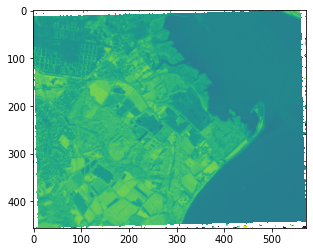

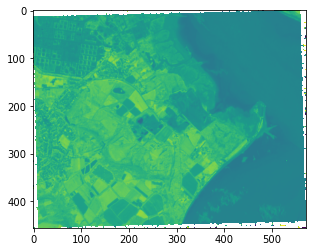

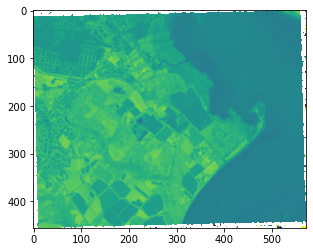

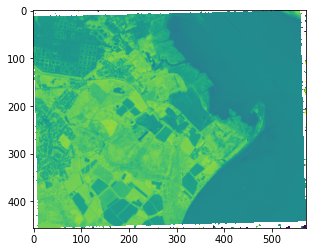

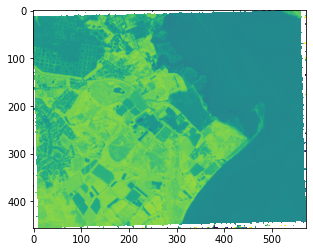

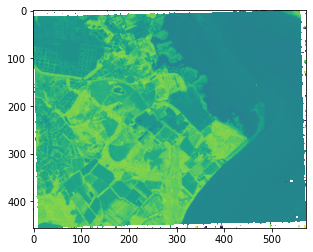

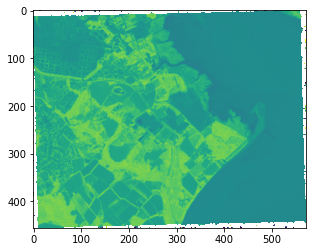

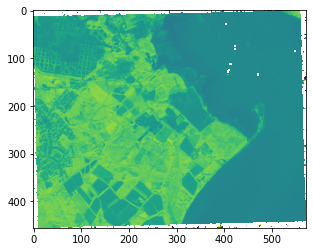

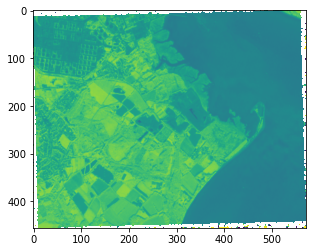

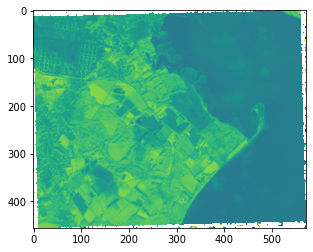

In [21]:
# Empty container to store ndvi file names
ndviDates = []
# List of dates of multispectral images
dates     = os.listdir(fileLoc+'S2/Months/')
dates.sort()     # sort dates chronologically 

# Empty containers for storing raster images
rgbCCC    = [] 
ndviClip  = []

# Loop through dates sequentially to extract multspectral images and NDVI values.
for date in dates:
    dataDate = date
    # Set input directory
    in_dir = f'{fileLoc}S2/Months/{dataDate}/'
    # Sentinel-2 bands to be used (i.e., all 10m bands)
    bands = ['B02','B03','B04','B08']

    #multiBand = []
    # Empty container to store multispectral image
    multiImg  = []

    # Loop through spectral bands for each date's image and clip to roi
    for band in bands:
        # Search through EO data file for relevant band
        file = glob.glob(in_dir + f'/**/*_{band}_10m.jp2', recursive = True)
        # Open spectral band with gdal
        bandImg = gdal.Open(file[0])
        
        # Clip band to ROI
        clipFile = in_dir + f's2_{dataDate}_{band}_{location}_cp_v4.jp2'
        # Export clipped band to file
        bandClip = gdal.Warp(clipFile, bandImg, cutlineDSName = f'{fileLoc}/Shapefiles\\_roi.shp',
                      cropToCutline = True, dstNodata = np.nan)
        # Store band data in multiband container
        multiImg.append(gdal.Open(clipFile))

    # Specify order of bands in Red, Green, and Blue combination 
    rgbCombo = [2,1,0]
    # Empty container for each date's multiband image 
    mbImage = []

    # Define meta data for raster band export
    ds   = multiImg[0]           # select first band
    gt   = ds.GetGeoTransform()  # extract geotransformation from band
    proj = ds.GetProjection()    # extract projection from band 

    # Create output filename based on input name 
    multiBand_name = in_dir + f's2_{dataDate}_{location}_multiBand.tif'

    # Stack spectral bands into multispectal image
    outvrt = '/vsimem/stacked.vrt'  # /vsimem is special in-memory virtual "directory"
    # Stack bands
    outds = gdal.BuildVRT(outvrt, multiImg, separate=True)
    # Export multispectral image
    outds = gdal.Translate(multiBand_name, outds)
    # Close dataset
    outds = None

    # Create true colour image
    # Loop through defined RGB combo and apply required contrast stretch function
    for band in rgbCombo:
        # use 98% contrast stretch (scallCCC)
        mbImage.append(scaleCCC(multiImg[band].ReadAsArray()))
    # Add processed image to list of all rgb date sequence
    rgbCCC.append(np.dstack((mbImage)))
    
    # Create NDVI Band
    #Extract Red and NIR bands from multi band container (use NP.int16 data type to express values in correct values)
    redBand = multiImg[2].ReadAsArray().astype(np.int16)
    nirBand = multiImg[3].ReadAsArray().astype(np.int16)
    # Use NDVI function to derive NDVI band
    ndviBand = ndvi(redBand,nirBand)#.astype(np.longdouble)
    
    # Plot NDVI band to validate (optional)
    plt.figure()
    plt.imshow(ndviBand)

    # Create output filename based on input name 
    outfile_name = in_dir + f's2_{dataDate}_{location}_NDVI_v1.tif'
    
    # Add ndvi band to NDVI date sequence
    ndviClip.append(ndviBand) 

    # Export NDVI band using derived metadata
    driver = gdal.GetDriverByName("GTiff")       # Get correct gdal driver for Geotiff
    driver.Register()                            # Register driver
    # Create empty raster later with correct data type (GDT_Float32 - allows decimal values)
    outds = driver.Create(outfile_name, xsize = ndviBand.shape[1],
                          ysize = ndviBand.shape[0], bands = 1,
                          eType = gdal.GDT_Float32)
    # Set geotransformation data (from derived meta data)
    outds.SetGeoTransform(gt) 
    outds.SetProjection(proj)
    # Write NDVI values to empty raster band
    outband = outds.GetRasterBand(1)
    outband.WriteArray(ndviBand)
    outband.SetNoDataValue(np.nan)
    outband.FlushCache()
    del outband
    
    # Add NDVI file name to list of files to call later
    ndviDates.append(outfile_name)

    # close your datasets and bands!!!
    outband = None
    outds = None
    
    # Extract NDVI values per tree location point data
    ndviVals = rs.zonal_stats(gdf, outfile_name,stats="max")#,geojson_out=True, copy_properties=True)
    # Attribute tree location df with NDVI values
    gdf[f'n_{date}'] = [x['max'] for x in ndviVals]

# Sort ndvidates into date order
ndviDates.sort()

In [23]:
dates

['01.Jan23',
 '02.Feb',
 '03.Mar',
 '04.Apr',
 '06.Jun',
 '07.Jul',
 '08.Aug',
 '10.Oct',
 '11.Nov',
 '12.Dec']

## Calculate NDVI change raster & attribute point file with change values

Fawley_IMIC_v1\S2/Months/01.Jan23/s2_01.Jan23_Fawley_IMIC_NDVI_v1.tif
Fawley_IMIC_v1\S2/Months/02.Feb/s2_02.Feb_Fawley_IMIC_NDVI_v1.tif
Fawley_IMIC_v1\S2/Months/02.Feb/s2_02.Feb_Fawley_IMIC_NDVI_v1.tif
Fawley_IMIC_v1\S2/Months/03.Mar/s2_03.Mar_Fawley_IMIC_NDVI_v1.tif
Fawley_IMIC_v1\S2/Months/03.Mar/s2_03.Mar_Fawley_IMIC_NDVI_v1.tif
Fawley_IMIC_v1\S2/Months/04.Apr/s2_04.Apr_Fawley_IMIC_NDVI_v1.tif
Fawley_IMIC_v1\S2/Months/04.Apr/s2_04.Apr_Fawley_IMIC_NDVI_v1.tif
Fawley_IMIC_v1\S2/Months/06.Jun/s2_06.Jun_Fawley_IMIC_NDVI_v1.tif
Fawley_IMIC_v1\S2/Months/06.Jun/s2_06.Jun_Fawley_IMIC_NDVI_v1.tif
Fawley_IMIC_v1\S2/Months/07.Jul/s2_07.Jul_Fawley_IMIC_NDVI_v1.tif
Fawley_IMIC_v1\S2/Months/07.Jul/s2_07.Jul_Fawley_IMIC_NDVI_v1.tif
Fawley_IMIC_v1\S2/Months/08.Aug/s2_08.Aug_Fawley_IMIC_NDVI_v1.tif
Fawley_IMIC_v1\S2/Months/08.Aug/s2_08.Aug_Fawley_IMIC_NDVI_v1.tif
Fawley_IMIC_v1\S2/Months/10.Oct/s2_10.Oct_Fawley_IMIC_NDVI_v1.tif
Fawley_IMIC_v1\S2/Months/10.Oct/s2_10.Oct_Fawley_IMIC_NDVI_v1.tif
Fawley

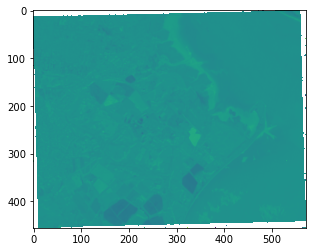

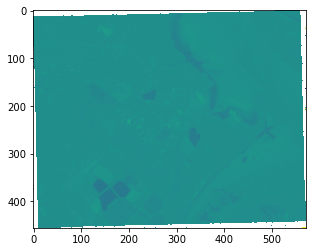

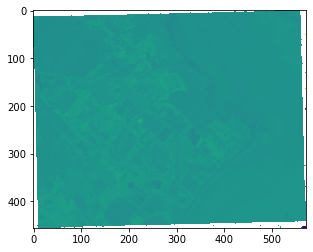

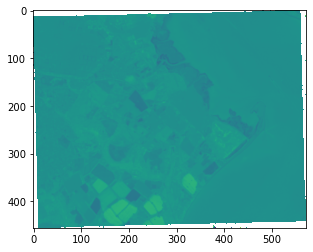

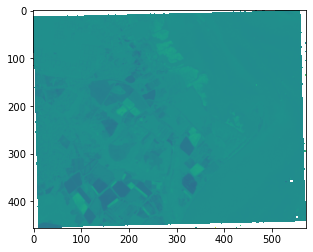

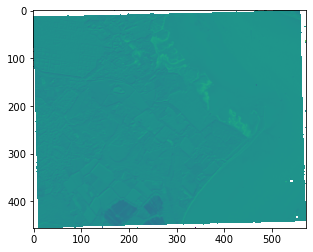

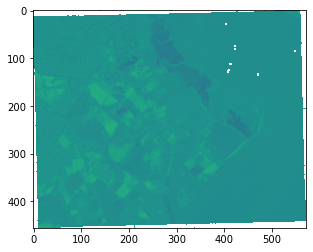

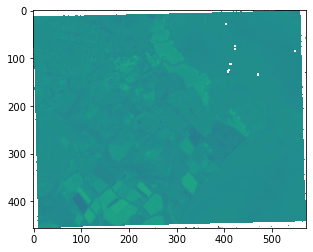

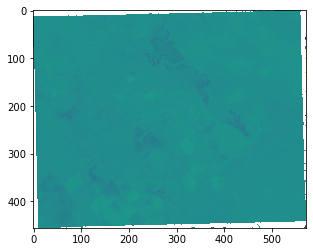

In [31]:
# Empty container for change bands
changeData = []

#Sort ndvidates into date order
ndviDates.sort()

# Initiate count value
n = 0
# Loop through NDVI dates comparing sequestial images (2nd date - 1st date)
while n < len(dates)-1:
    # Open two sequential date NDVI images to compare
    date1 = gdal.Open(ndviDates[n]).ReadAsArray()
    date2 = gdal.Open(ndviDates[n+1]).ReadAsArray()
    print(ndviDates[n])
    print(ndviDates[n+1])
    
    # Calculate difference in NDVI bands (2nd date - 1st date)
    changeBand = np.subtract(date2,date1)
    # Add change band to container 
    changeData.append(changeBand)
    
    # Plot calculated change image (optional) 
    plt.figure()
    plt.imshow(changeBand)    
    
    # Set output directory
    out_dir = f'{fileLoc}S2/Change/'
    # Create output filename based on input name 
    outfile_name = out_dir + f's2_{dates[n]}_{dates[n+1]}_NDVI_change.tif'
    
    # Export NDVI change band using derived metadata
    driver = gdal.GetDriverByName("GTiff")       # Get correct gdal driver for Geotiff
    driver.Register()                            # Register driver
    # Create empty raster later with correct data type (GDT_Float32 - allows decimal values)
    outds = driver.Create(outfile_name, xsize = changeBand.shape[1],
                          ysize = changeBand.shape[0], bands = 1, 
                          eType = gdal.GDT_Float32)
    # Set geotransformation data (from derived meta data)
    outds.SetGeoTransform(gt)
    outds.SetProjection(proj)
    # Write NDVI change values to empty raster band
    outband = outds.GetRasterBand(1)
    outband.WriteArray(changeBand)
    outband.SetNoDataValue(np.nan)
    outband.FlushCache()

    # close your datasets and bands!!!
    outband = None
    outds = None
    
    # Extract ndvi change values per point
    ndviChan = rs.zonal_stats(gdf, outfile_name,stats="max")#,geojson_out=True, copy_properties=True)
    # Attribute df with ndvi values
    gdf[f'C_{dates[n]}_{dates[n+1]}'] = [x['max'] for x in ndviChan]
    
    # Update count 
    n +=1

## Save point file data with NDVI values

In [32]:
gdf.to_file(filename=fileLoc+pointFileName+f'_{exportCRS}_exp.shp', driver="ESRI Shapefile")

C:\Users\Mark.Hennen\AppData\Local\Temp\ipykernel_10104\4259171730.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(filename=fileLoc+pointFileName+f'_{exportCRS}_exp.shp', driver="ESRI Shapefile")


## Visualise RGB, NDVI, and CHange detection images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

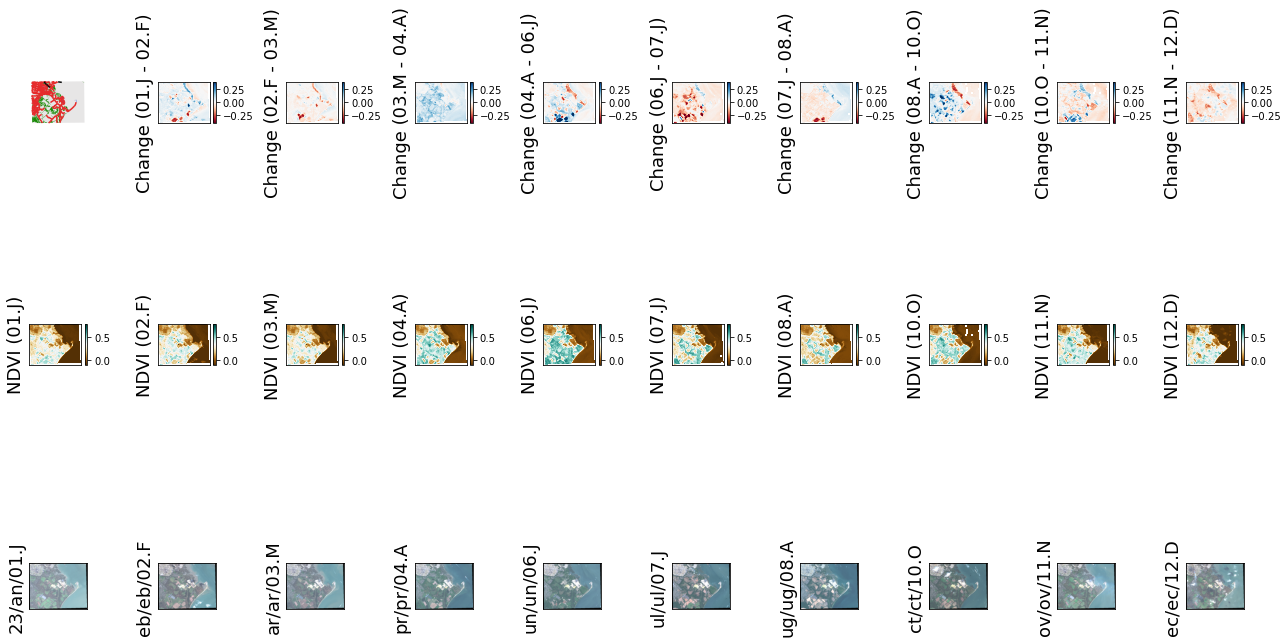

In [33]:
# Define plotting functions
# Plot with colourbar  
def pltCbar (axis, plot, minim, maxim, colors):#,title):
    divider = make_axes_locatable(axis)   
    cax = divider.append_axes('right', size='5%', pad=0.05)   
    im = axis.imshow(plot, vmin = minim, vmax = maxim, cmap = colors)  
    fig.colorbar(im, cax=cax, orientation='vertical')  
    #axis.set_title(title, fontsize=16, pad = 10)  
    axis.tick_params(labelcolor="k", labelbottom = False, labelleft=False, bottom=False, left=False)

#Plot mutlispectral image
def pltRGB (axis, plot):#,title):    
    im = axis.imshow(plot)   
    #axis.set_title(title, fontsize=16, pad = 10)    
    axis.tick_params(labelcolor="k", labelbottom = False, labelleft=False, bottom=False, left=False)

# OS Layer colour dictioary
os_layers = ['Road', 'RailwayTrack', 'Building', 'Woodland']
LaCovCol = ['#E62B2B','#080808', '#1E4CDE', '#188A06']
labCol  = dict(zip(os_layers, LaCovCol))
    
# Define subplot shape (height, width)
plotShape = (3, len(dates))
# Define plot size
fig, ax = plt.subplots(figsize=(18,12))
# Define plot background colour
fig.patch.set_facecolor('white')

# Plot time series of data
# Initiate loop count
count = 0
# Loop over x and y subplots 
for x in range(0, plotShape[0]):    
    for y in range(0, plotShape[1]):  
        # Define subplot position and shape
        ax = plt.subplot2grid((plotShape), (x, y), colspan=1, rowspan=1)        
        # Top left subplot plot
        if count == 0: 
            # Plot OS layer describing ROI 
            roi.plot(ax=ax, color="#E7E6E6")            
            for i in os_layers:  
                folder = f'{i}_clip'   # Layer folder location   
                fLoc   = f'{fileLoc}/OS/'                # Layer file location              
                # Load os layer file               
                layer = gpd.read_file(fLoc + folder + f'/{folder}.shp')                
                if len(layer) <1: # check if layer exisits within ROI, if no: Skip                   
                    continue
                # Plot OS Layer 
                layer.plot(ax=ax, color = labCol[i], label = i)            
                #ax.legend()            
                ax.set_ylabel("Geospatial Layers", fontsize=18)           
                ax.set_axis_off()    # Turn axis co-ordinates off    
        else:
            # Top row: change detection band
            if x == 0:
                title = f'{dates[y-1][0:4]} - {dates[y][0:4]}'                
                pltCbar(ax,changeData[y-1],-0.4, 0.4, 'RdBu')                
                ax.set_ylabel(f'Change ({title})',fontsize=18)            
            # Middle row: NDVI band
            elif x == 1:
                pltCbar(ax,ndviClip[y],-0.1, 0.8, 'BrBG')                
                ax.set_ylabel(f'NDVI ({dates[y][0:4]})',fontsize=18)            
            # Bottom row: True colour RGB band
            elif x == 2:                
                pltRGB(ax, rgbCCC[y])               
                ax.set_ylabel(f'{dates[y][-2:]}/{dates[y][4:6]}/{dates[y][0:4]}',fontsize=18)        
        # Update loop count    
        count +=1
            
plt.tight_layout()
plt.show()

## Time series analysis

In [28]:
gdf = gpd.read_file(fileLoc+pointFileName+f'_{exportCRS}_exp.shp')

Ddates = [x for x in gdf.columns if 'c_' not in x.lower() if 'n_' in x.lower()]
Ddates.sort()

popMean = []
popStd = []

# Loop through NDVI/NDVI Change dates
for date in Ddates:
    # Subset data by date loop
    popData = gdf[f'{date}']

    # Add population and sample mean/standard deviation value to timeseries container
    popMean.append(popData.mean())
    popStd.append(popData.std())


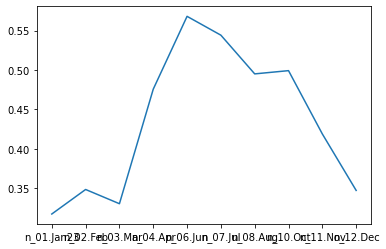

In [29]:
plt.plot(Ddates,popMean)

In [30]:
Ddates

['n_01.Jan23',
 'n_02.Feb',
 'n_03.Mar',
 'n_04.Apr',
 'n_06.Jun',
 'n_07.Jul',
 'n_08.Aug',
 'n_10.Oct',
 'n_11.Nov',
 'n_12.Dec']